# Population Splitting for IBD Exomes v36 - 09/05/19
## Author: Guhan Venkataraman

### Part 1: 1kG Superpopulation Prediction

The below cell takes care of the necessary imports.

### Note: hailctl dataproc start guhancluster --vep GRCh38 --zone us-west1-b --num-workers 120 --worker-machine-type n1-standard-16 --master-machine-type n1-highmem-32 --worker-boot-disk-size 100

In [154]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import os

The next cell reads in the files containing the lists of Thousand Genomes and CCDG Genomes samples.

In [180]:
with open('../sample_lists/1kg_samples.tsv') as f:
    kg_samples = f.readlines()
kg_samples = [x.strip() for x in kg_samples]

with open('../sample_lists/ccdg_samples.tsv') as f:
    ccdg_samples = f.readlines()
ccdg_samples = [x.strip() for x in ccdg_samples]

Now, we read in the PC projections of 1kG loadings onto all samples (generated via `pca.py` and the Hail package, in this same directory), parsing the raw file (which is messily formatted) into a human readable format and writing to file.

In [181]:
All = pd.read_table('1kg_pca_projections_all_samples.tsv')
All['scores'] = All['scores'].str.replace('[', '').str.replace(']', '')
cols = ['PC'+ str(i) for i in range(10)]
All[cols] = All['scores'].str.split(',', expand=True).astype(np.float64)
cols = ['s'] + cols
All = All[cols]
All.to_csv('1kg_pca_projections_all_samples_clean.tsv', sep='\t', index=False)

In order to visualize the projections by dataset, we create a "dataset" column via the sample manifests we loaded up previously.

v36 samples: 55701
CCDG samples: 7911
1kG samples: 2504


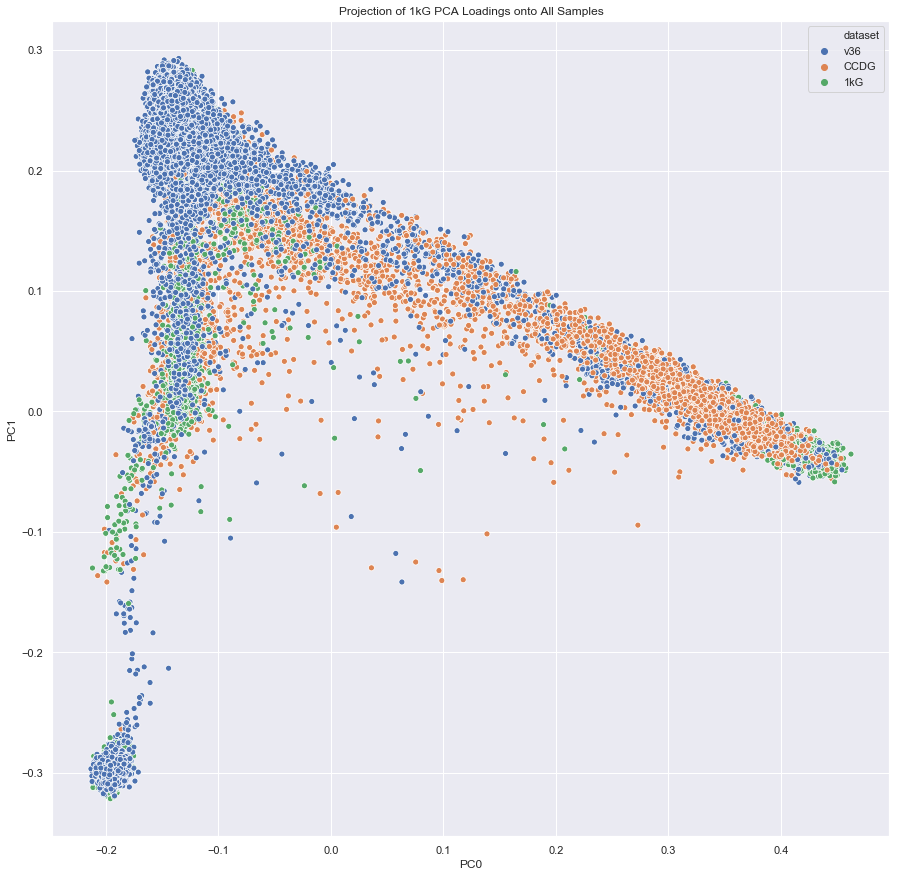

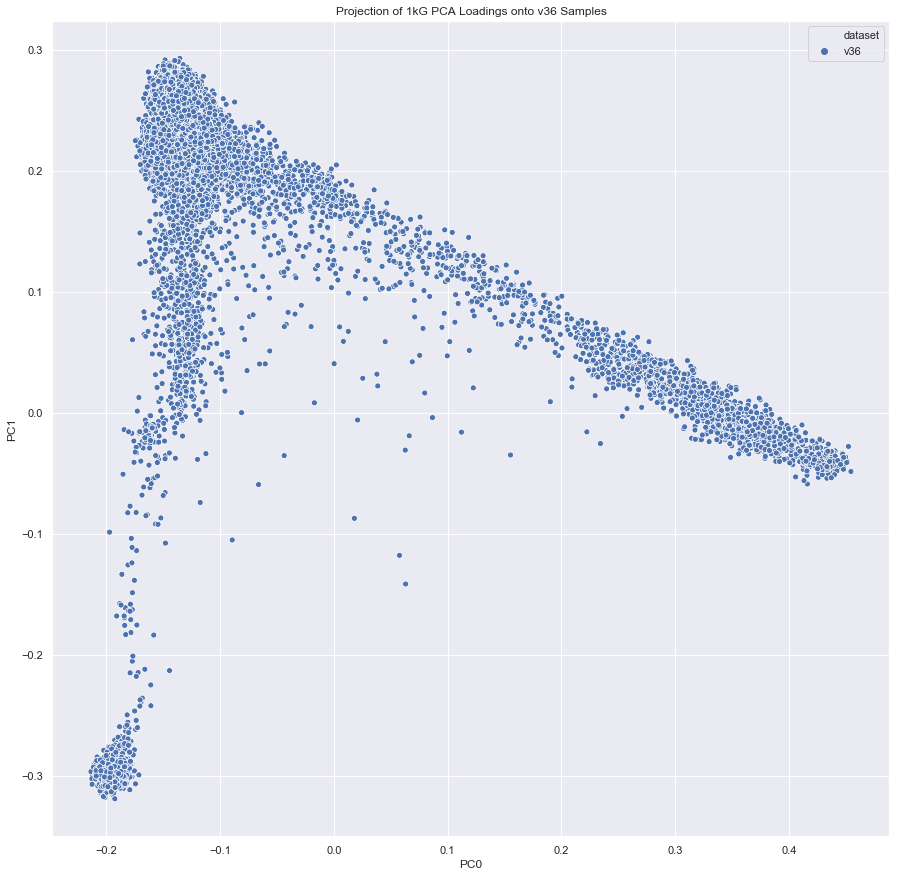

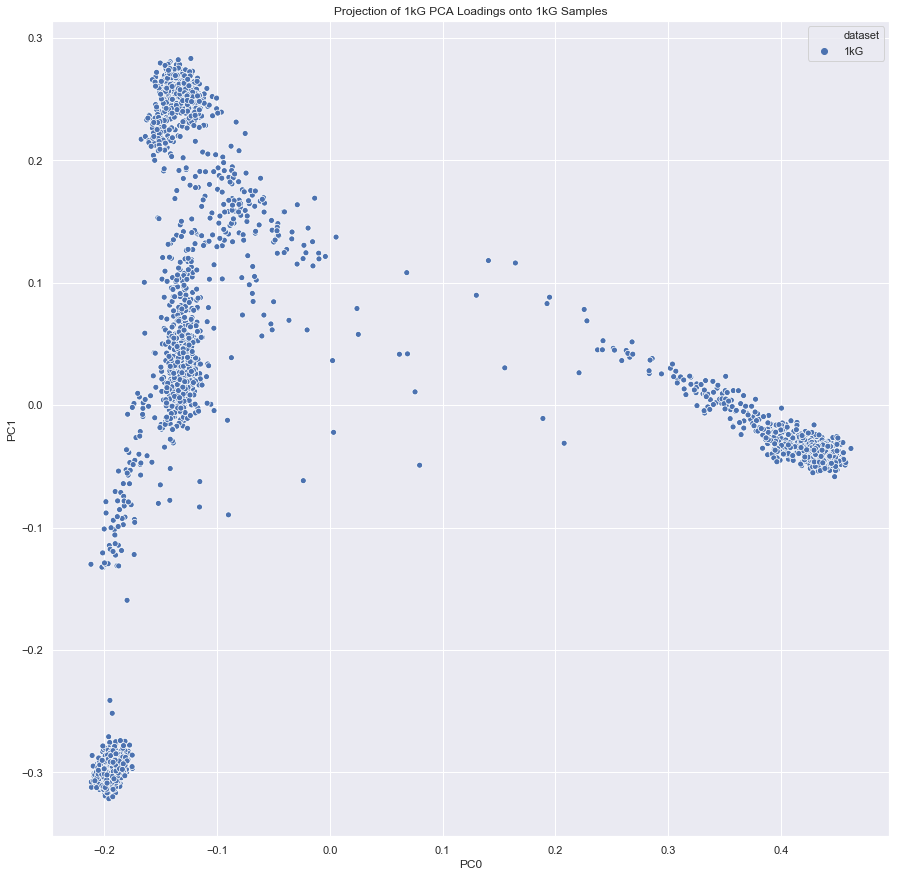

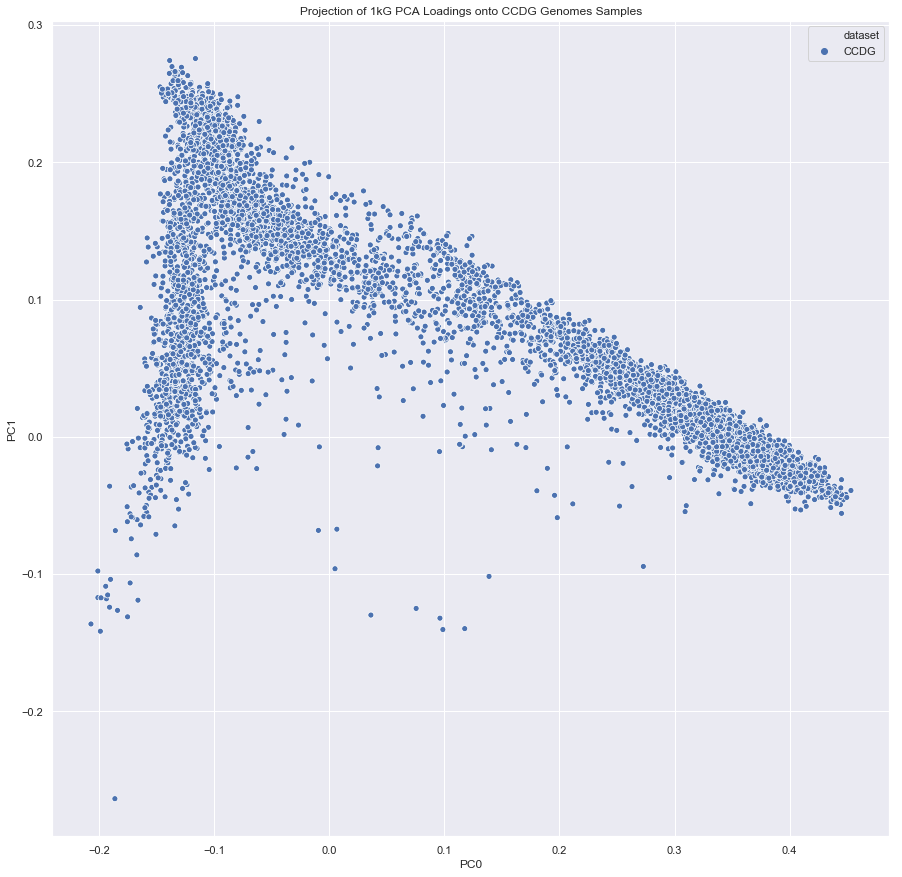

In [182]:
All['dataset'] = 'NA'
for i, row in All.iterrows():
    if (All.at[i, 's'] in kg_samples):
        All.at[i, 'dataset'] = '1kG'
    elif (All.at[i, 's'] in ccdg_samples):
        All.at[i, 'dataset'] = 'CCDG'
    else:
        All.at[i, 'dataset'] = 'v36'
CCDG = All[All['dataset'] == 'CCDG']
KG = All[All['dataset'] == '1kG']
v36 = All[All['dataset'] == 'v36']
print("v36 samples: " + str(len(v36)))
print("CCDG samples: " + str(len(CCDG)))
print("1kG samples: " + str(len(KG)))
# Graphs of each dataset, combined and separate
for dataset, name in zip([All, v36, KG, CCDG], ['All', 'v36', '1kG', 'CCDG Genomes']):
    plt.figure(figsize=(15,15))
    sns.set()
    sns.scatterplot('PC0', 'PC1', hue='dataset', label='', data=dataset).set_title('Projection of 1kG PCA Loadings onto ' + name + ' Samples')

The next step in this process is to do an iterative RF classification on the samples that do not yet have population labels.

The first RF is trained on 1kG data and labels - African-American (AFR), "American"/Hispanic/Native American (AMR), European (EUR), East Asian (EAS), and South Asian (SAS) - collectively referred to as "superpopulation labels". The RF predicts the superpopulation label of every sample in the dataset.

The second RF is trained to re-classify those classified as EUR in the previous step as members of Ashkenazi Jew (AJ), Finnish (FIN), Lithuanian (LIT), or Non-Finnish European (NFE) populations. Samples already labeled as such are the training data, and those EUR samples that don't yet have a sub-population classification will utilize predictions from this classifier.

In the end, we will always use the most accurate label possible. That is, if an AFR sample from the CCDG Genomes is explicitly already classified as such, regardless of whether or not the first or second RFs misclassify the sample, we will use the correct label.

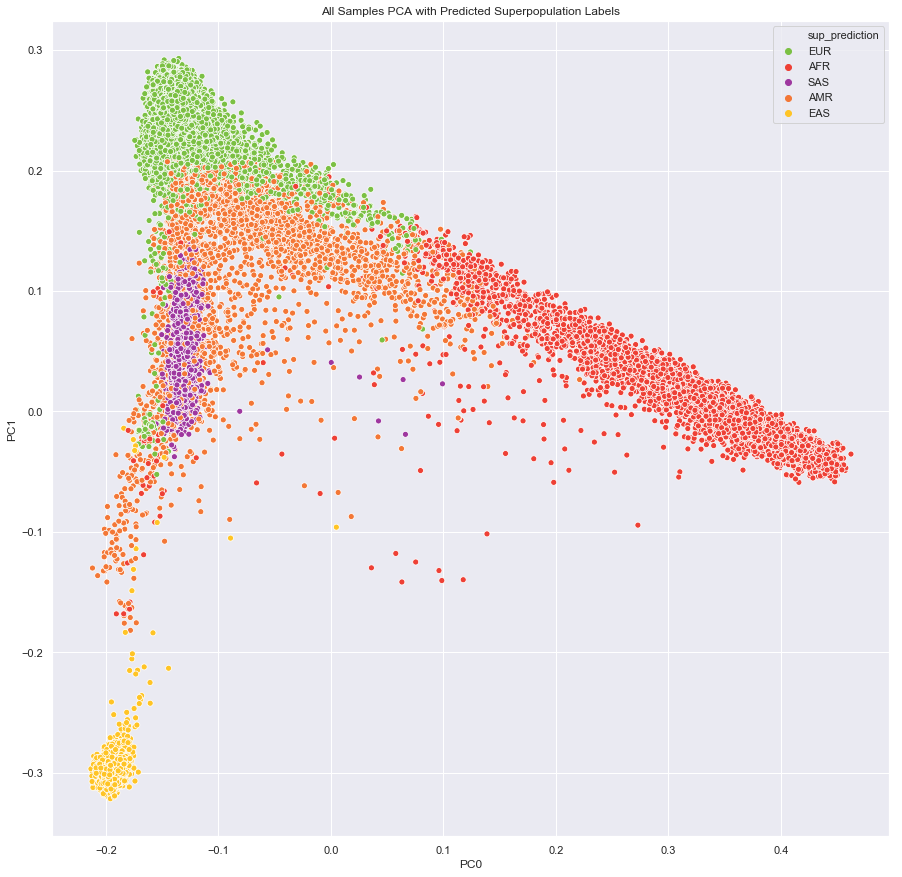

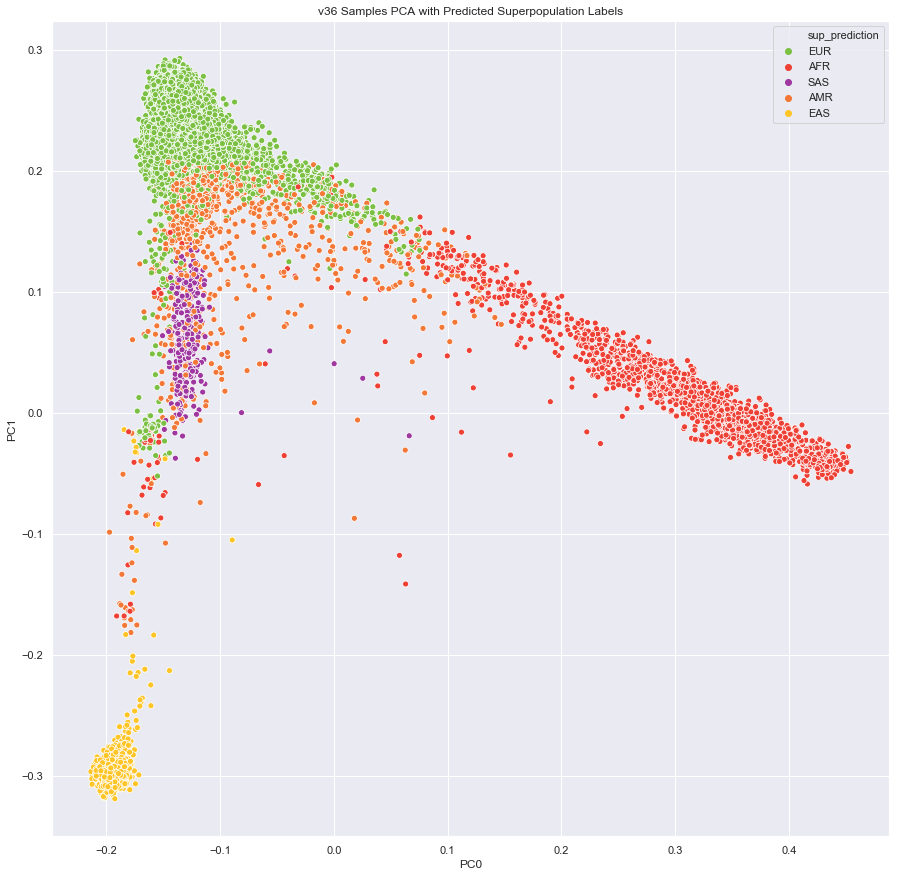

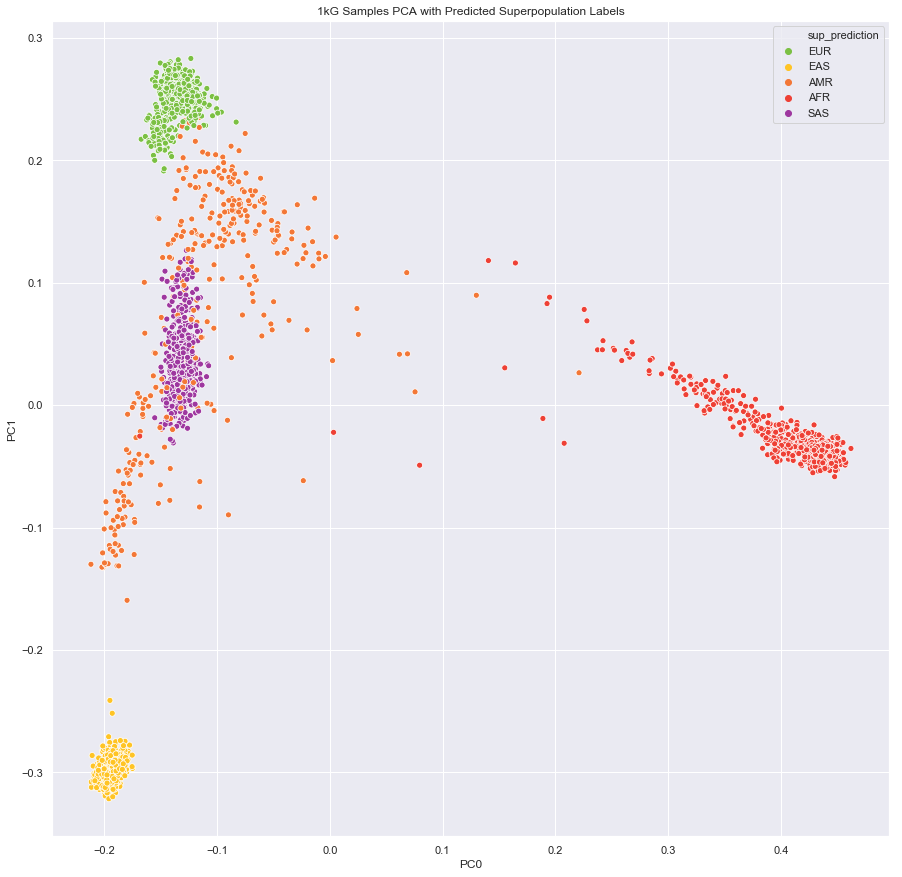

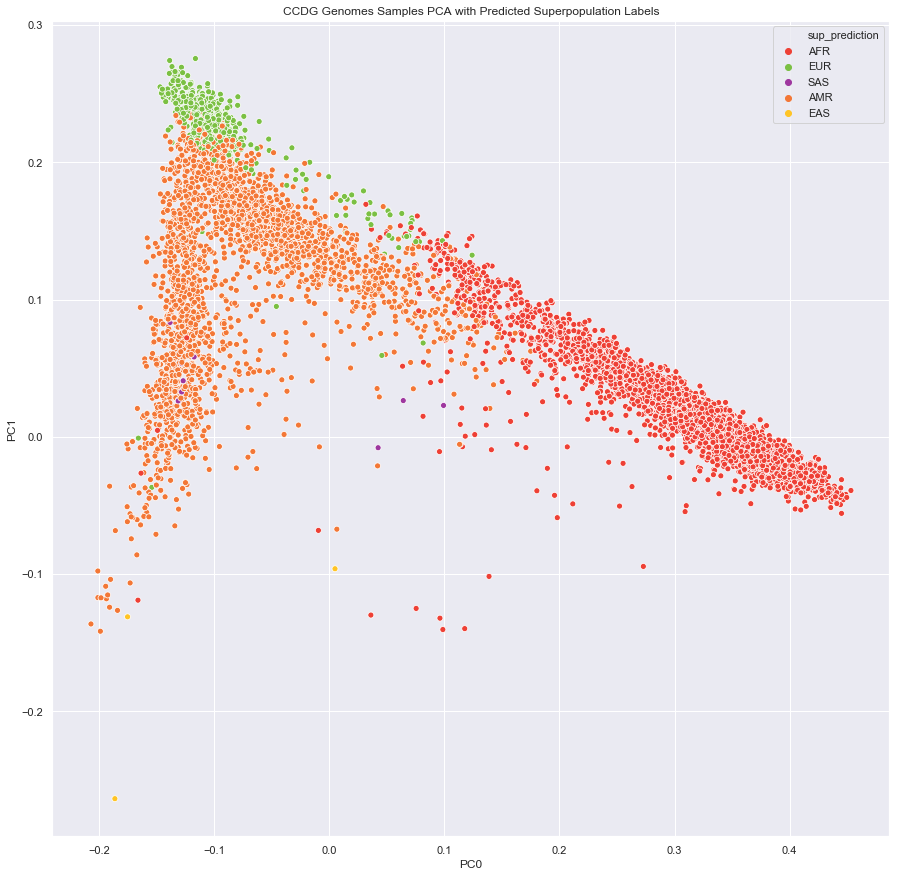

In [183]:
# Gathering train data
pc_data = pd.read_table('1kg_pca_projections_all_samples_clean.tsv')
kg = pd.read_table('1kgpop.tsv')
#Filter for those samples in our dataset
kg = kg.merge(pc_data, left_on='Sample name', right_on='s')

# Initializing and fitting the classifier
sup_rfc = RandomForestClassifier()
X_train = kg.columns[3:]
y_train = kg.columns[1]
sup_rfc.fit(kg[X_train], kg[y_train])
sup_pops = ['AFR', 'AMR', 'EAS', 'EUR', 'SAS']
pc_data['sup_prediction'] = sup_rfc.predict(pc_data[X_train])
for i, row in pc_data.iterrows():
    if (pc_data.at[i, 's'] in kg_samples):
        pc_data.at[i, 'dataset'] = '1kG'
    elif (pc_data.at[i, 's'] in ccdg_samples):
        pc_data.at[i, 'dataset'] = 'CCDG'
    else:
        pc_data.at[i, 'dataset'] = 'v36'
CCDG = pc_data[pc_data['dataset'] == 'CCDG']
KG = pc_data[pc_data['dataset'] == '1kG']
v36 = pc_data[pc_data['dataset'] == 'v36']

# Graphs of each dataset, combined and separate, with predicted superpopulation as hue
for dataset, name in zip([pc_data, v36, KG, CCDG], ['All', 'v36', '1kG', 'CCDG Genomes']):
    plt.figure(figsize=(15,15))
    sns.set()
    sns.scatterplot('PC0', 'PC1', hue='sup_prediction', data=dataset, palette=dict(AFR="#ee4035", AMR="#f37736", EAS="#ffc425", EUR="#7bc043", NA="#0392cf", SAS="#9e379f")).set_title(name + ' Samples PCA with Predicted Superpopulation Labels')

### Part 2: Sub-population Prediction

Now that we have superpopulation codes for each sample, the next step in the procedure is to retrieve sample-level sub-population annotations and diagnoses. We merge these data with our existing principal component data.

In [184]:
# Read in table with sub-populations and diagnoses
pops = pd.read_table('v36+ccdg_pop+diagnosis.tsv').drop_duplicates()
pops = pops.replace('AFRICAN AMERICAN', 'AFR')

pc_data = pc_data.merge(pops, left_on=['s'], right_on='SAMPLE_ID').drop('SAMPLE_ID',axis=1)
#NO POPULATION MAPPING for these
pc_data = pc_data[~(pc_data['COHORT'].isin(['ALM', 'NEC', 'FARMER']))]

It is important to note that the Random Forest classifier is just that - there is a certain degree of randomness to superpopulation label assignment for those non-obvious fringe cases. Thus, we have frozen the list of train and test samples below.

In [185]:
# For generating list of test and train samples
eur_pops = ['AJ', 'FIN', 'NFE', 'LIT']
unfinalized_pops = ['CONTROL', 'US- NIDDK', 'US- Other Cohorts', 'US- MGH PRISM']
if not os.path.exists('pc_data_sup_pop_freeze.tsv'):
    print("Writing...")
    pc_data.to_csv('pc_data_sup_pop_freeze.tsv', sep='\t', index=False)

Writing...


In [187]:
pc_data = pd.read_table('pc_data_sup_pop_freeze.tsv')
eur_train_data = list(pc_data[pc_data['RACE/ETHNICITY'].isin(eur_pops)]['s'])
eur_test_data = list(pc_data[(pc_data['sup_prediction'] == 'EUR') & (pc_data['RACE/ETHNICITY'].isin(unfinalized_pops))]['s'])
eur_samples_to_pca = set(eur_train_data).union(set(eur_test_data))
if not os.path.exists('eur_samples_to_pca.tsv'):
    with open('eur_samples_to_pca.tsv', 'w') as f:
        print("Writing...")
        f.write("s\n")
        for item in list(eur_samples_to_pca):
            f.write("%s\n" % item)

Writing...


Now that we have a freeze of train and test samples for the European classifier, the next step is to run PCA on these samples (`eur_pca.py`). This should generate a file called `eur_40_pca_scores.tsv.bgz` in the Google Cloud bucket, that can be copied over, renamed as `eur_40_pca_scores.tsv.gz`, and `gunzip`ed. We clean the file in the following cell.

In [168]:
def clean_eur_pc_data(filename, num_pcs, prefix):
    eur_pc_data = pd.read_table(filename)
    eur_pc_data['scores'] = eur_pc_data['scores'].str.replace('[', '').str.replace(']', '')
    eur_cols = [prefix + str(i) for i in range(num_pcs)]
    eur_pc_data[eur_cols] = eur_pc_data['scores'].str.split(',', expand=True).astype(np.float64)
    eur_cols = ['s'] + eur_cols
    eur_pc_data = eur_pc_data[eur_cols]
    eur_pc_data.to_csv(filename[:-4] + '_clean.tsv', sep='\t', index=False)
    return eur_pc_data

Before assigning populations, we should clean the data for outliers. We read in the data and plot the first couple of PCs to get a sense as to which samples to exclude.

In [177]:
eur_pc_data = clean_eur_pc_data('eur_40_pca_scores.tsv', 40, 'EUR_PC')
eur_pc_data = eur_pc_data.merge(pops, left_on=['s'], right_on='SAMPLE_ID').drop('SAMPLE_ID',axis=1)

s   EUR_PC0   EUR_PC1  EUR_PC2   EUR_PC3  EUR_PC4   EUR_PC5  \
11528  C00-0511 -0.029777  0.022389 -0.01275  0.015335 -0.00281 -0.006907   

        EUR_PC6   EUR_PC7   EUR_PC8    ...     EUR_PC33  EUR_PC34  EUR_PC35  \
11528 -0.055364  0.032535 -0.021783    ...      0.00038 -0.004492  0.004949   

       EUR_PC36  EUR_PC37  EUR_PC38  EUR_PC39  RACE/ETHNICITY  DIAGNOSIS  \
11528 -0.008948  0.005335 -0.011152  0.000959        HISPANIC    CONTROL   

         COHORT  
11528  MCGOVERN  

[1 rows x 44 columns]

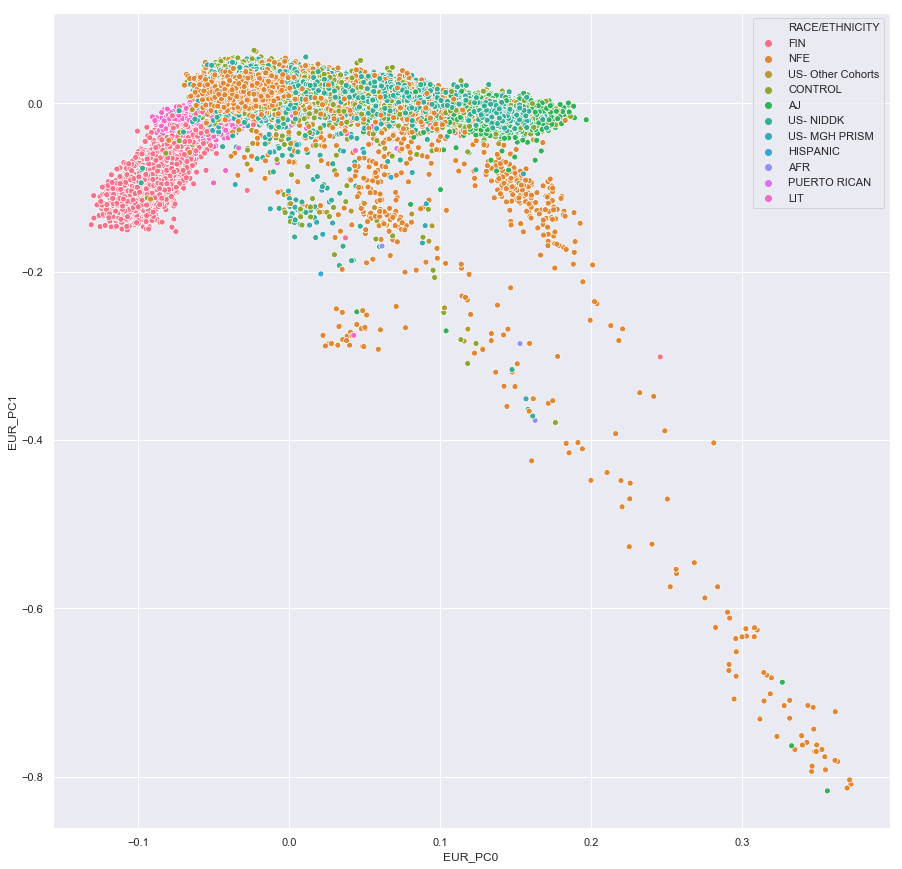

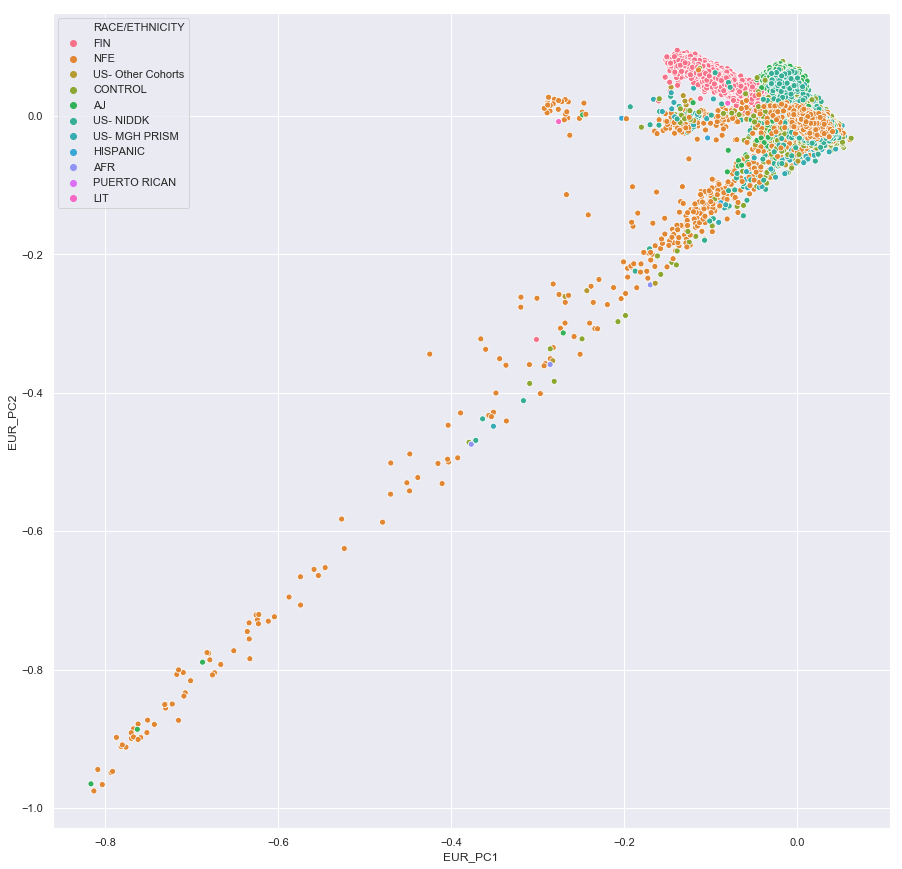

In [170]:
eur_cols = ['EUR_PC' + str(i) for i in range(10)]
for i in range(2):
    plt.figure(figsize=(15,15))
    sns.set()
    sns.scatterplot(eur_cols[i], eur_cols[i+1], hue='RACE/ETHNICITY', data=eur_pc_data)

As we can see, there is a long tail of people on the `EUR_PC1` spectrum that are probably messing up the rest of the PCA. We will remove the individuals that have `EUR_PC1` values less than -0.2 from the analysis.

In [171]:
outliers = list(eur_pc_data[eur_pc_data['EUR_PC1'] < -0.2]['s'])

if not os.path.exists('eur_outliers.tsv'):
    with open('eur_outliers.tsv', 'w') as f:
        print("Writing...")
        f.write("s\n")
        for item in list(outliers):
            f.write("%s\n" % item)
print(len(outliers))

156


We will now run PCA again for the European samples minus these 253 outliers (`eur_outlier_pca.py`). This should generate a file called `eur_outlier_40_pca_scores.tsv.bgz` in the Google Cloud bucket, that can be copied over, renamed as `eur_outlier_40_pca_scores.tsv.gz`, and `gunzip`ed. We clean the file in the following cell.

In [174]:
eur_outlier_pc_data = clean_eur_pc_data('eur_outlier_40_pca_scores.tsv', 40, 'EUR_PC')
eur_outlier_pc_data = eur_outlier_pc_data.merge(pops, left_on=['s'], right_on='SAMPLE_ID').drop('SAMPLE_ID',axis=1)

s   EUR_PC0  EUR_PC1   EUR_PC2   EUR_PC3   EUR_PC4   EUR_PC5  \
11434  C00-0511 -0.028396  0.02573 -0.015389 -0.003912 -0.007574 -0.060157   

        EUR_PC6   EUR_PC7   EUR_PC8    ...     EUR_PC33  EUR_PC34  EUR_PC35  \
11434  0.021237  0.001711 -0.022555    ...     0.037518  0.002646   0.00358   

       EUR_PC36  EUR_PC37  EUR_PC38  EUR_PC39  RACE/ETHNICITY  DIAGNOSIS  \
11434 -0.002504 -0.014915  0.014201  0.003337        HISPANIC    CONTROL   

         COHORT  
11434  MCGOVERN  

[1 rows x 44 columns]

The following logic helps set train and test data - the finalized populations are kept aside for training.

In [175]:
finalized_pops = ['AFR', 'AJ', 'EAS', 'FIN', 'HISPANIC', 'NFE', 'PUERTO RICAN', 'LIT']
for i, row in pc_data.iterrows():
    if (pc_data.at[i, 'RACE/ETHNICITY'] in finalized_pops):
        pc_data.at[i, 'sub_prediction'] = pc_data.at[i, 'RACE/ETHNICITY']
    else:
        pc_data.at[i, 'sub_prediction'] = pc_data.at[i, 'sup_prediction']

We merge the EUR PCs with the original PCs and annotations.

In [72]:
eur_train_pc_data = eur_outlier_pc_data[eur_outlier_pc_data['s'].isin(eur_train_data)].merge(pc_data)
eur_test_pc_data = eur_outlier_pc_data[eur_outlier_pc_data['s'].isin(eur_test_data)].merge(pc_data)

We now train the second classifier and predict to generate labels for all non-classified EUR samples.

In [73]:
eur_rfc = RandomForestClassifier()
X_train = eur_train_pc_data.columns[1:41]
y_train = eur_train_pc_data.columns[-1:]
eur_rfc.fit(eur_train_pc_data[X_train], eur_train_pc_data[y_train])
eur_test_pc_data['eur_prediction'] = eur_rfc.predict(eur_test_pc_data[X_train])
eur_train_pc_data['eur_prediction'] = np.nan

eur_pc_data = pd.concat([eur_train_pc_data, eur_test_pc_data])
pc_data = pc_data[~pc_data['s'].isin(outliers)]
pc_data = eur_pc_data.merge(pc_data, how='outer')

for i, row in pc_data.iterrows():
    if pc_data.at[i, 's'] in eur_test_data:
        pc_data.at[i, 'sub_prediction'] = pc_data.at[i, 'eur_prediction']

/Users/guhan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


Calculated EUR PCs are visualized below.

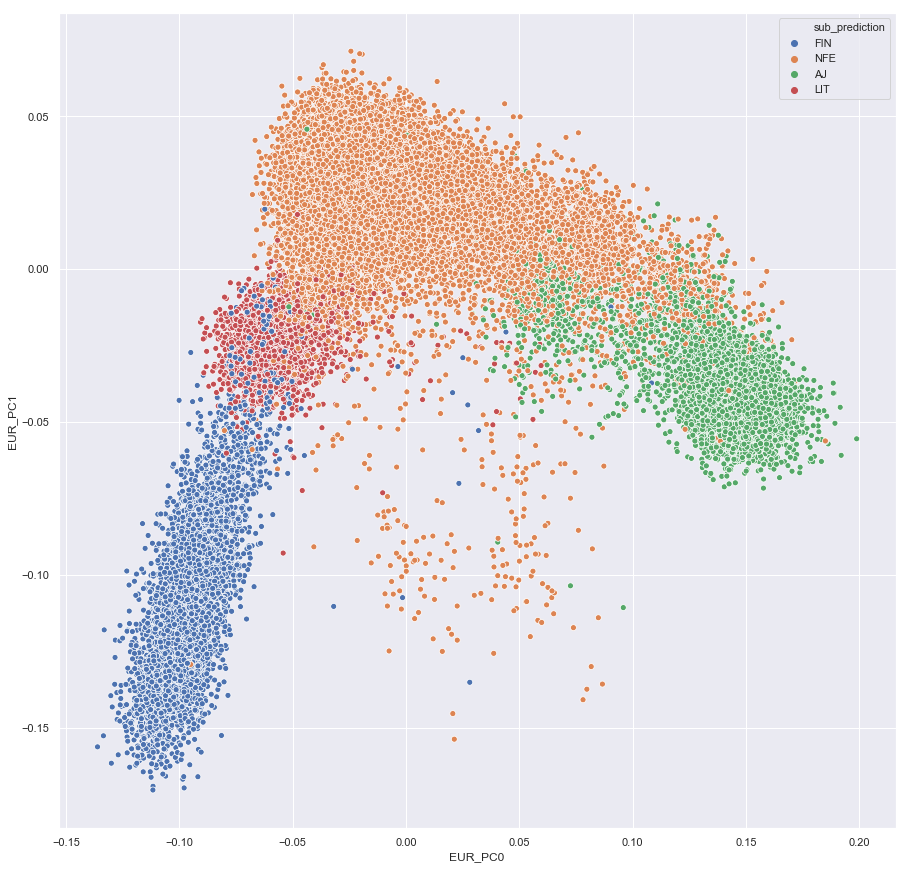

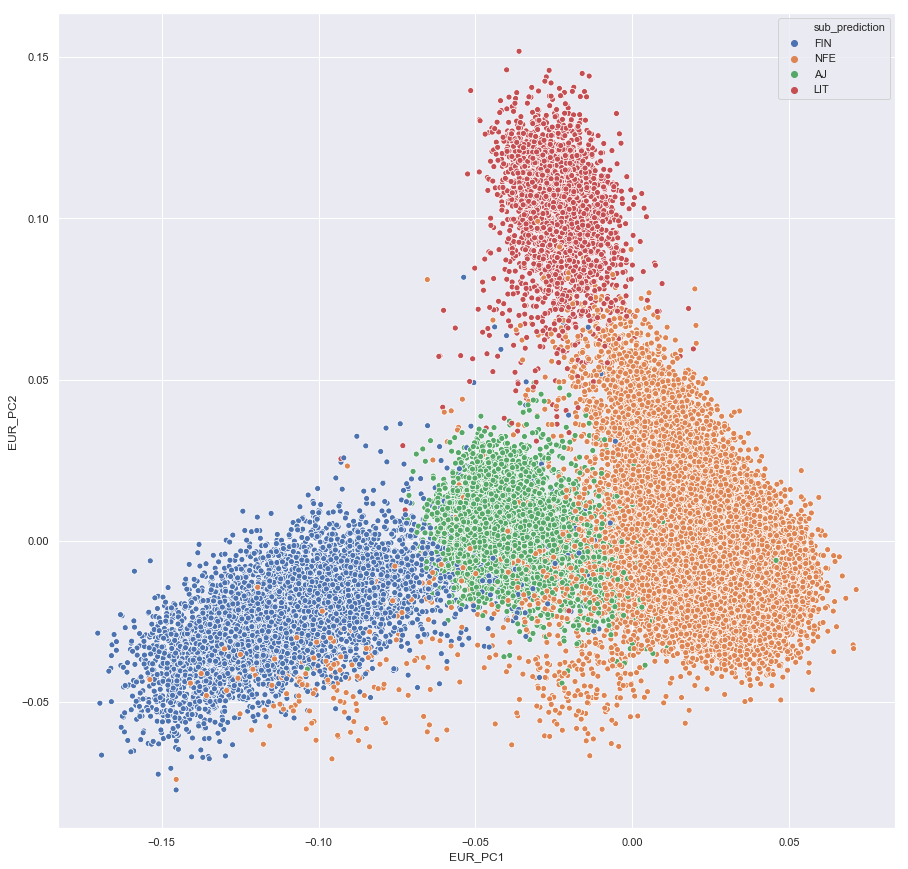

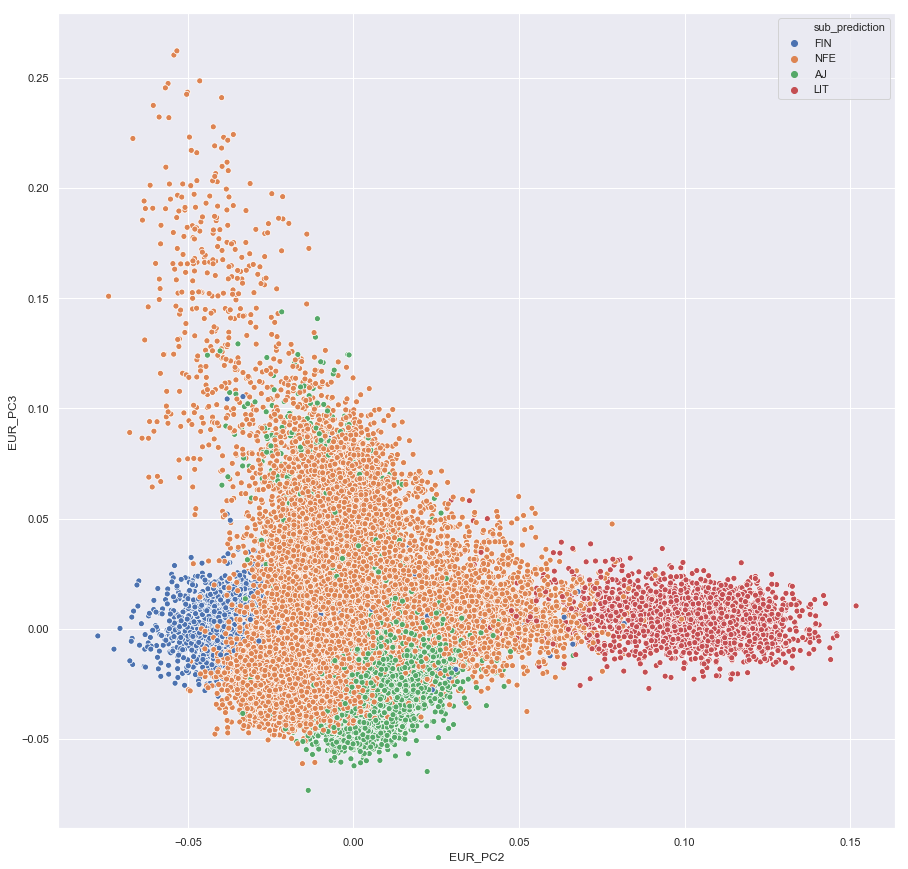

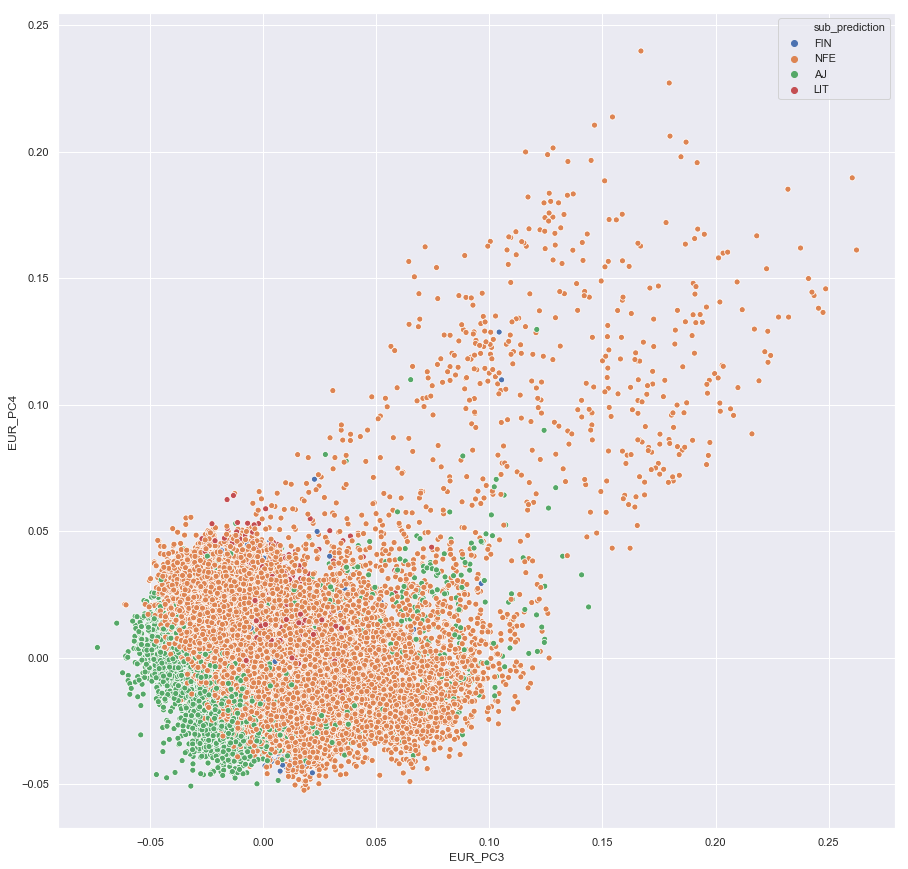

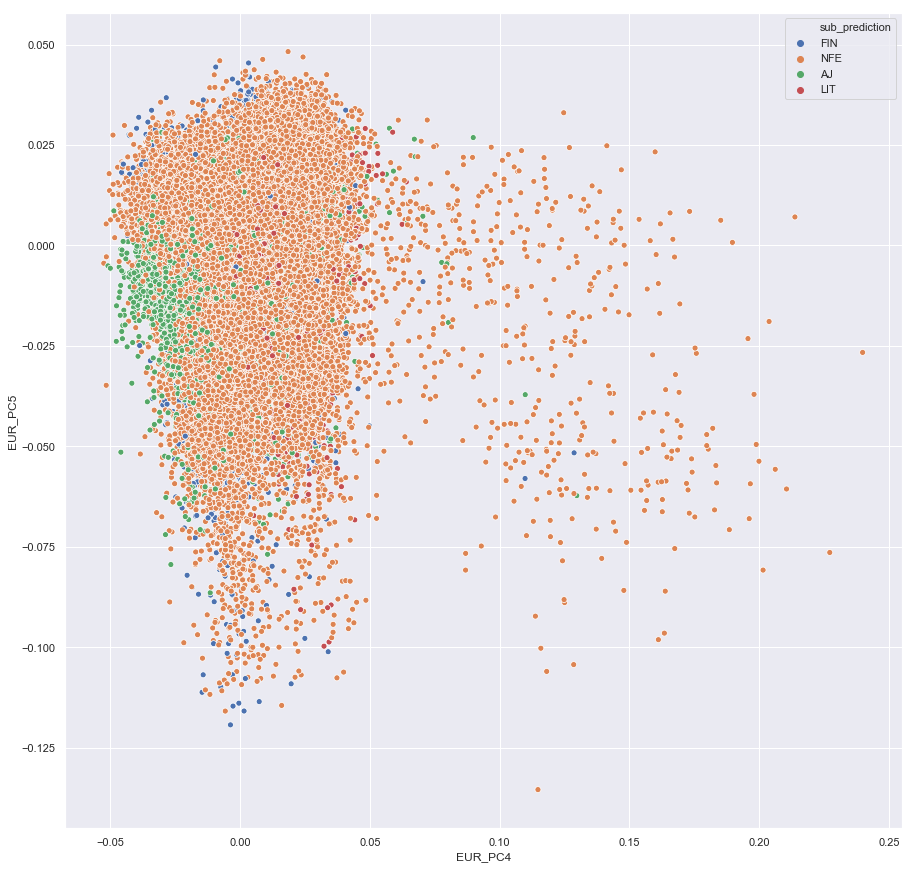

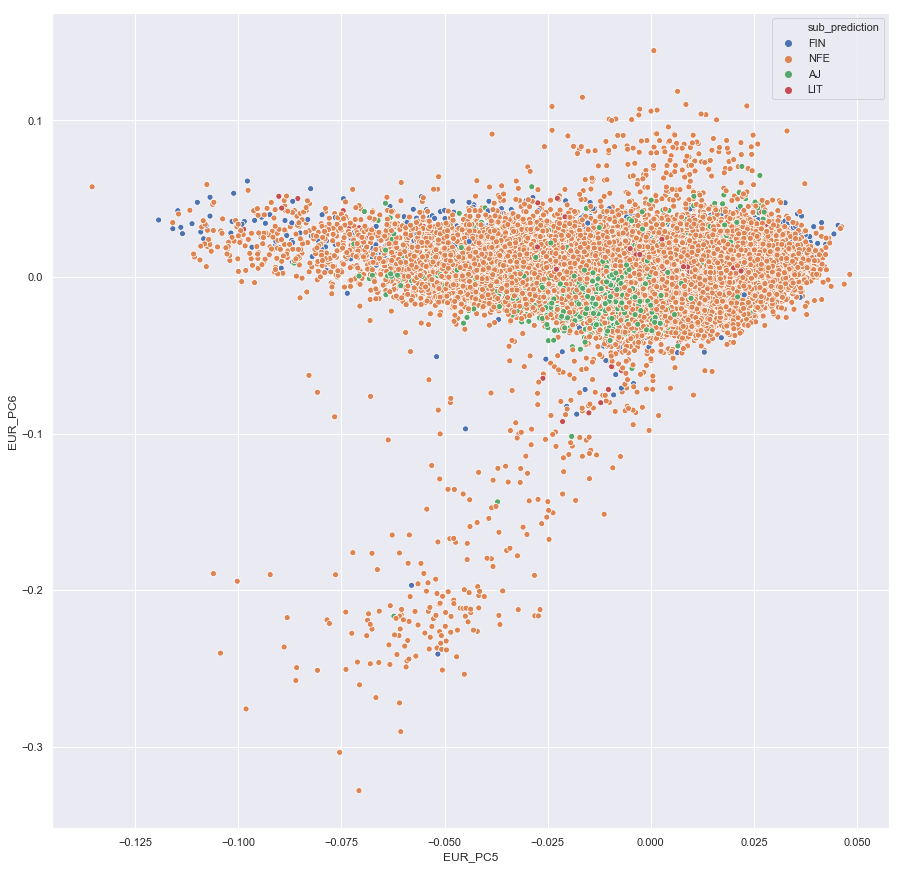

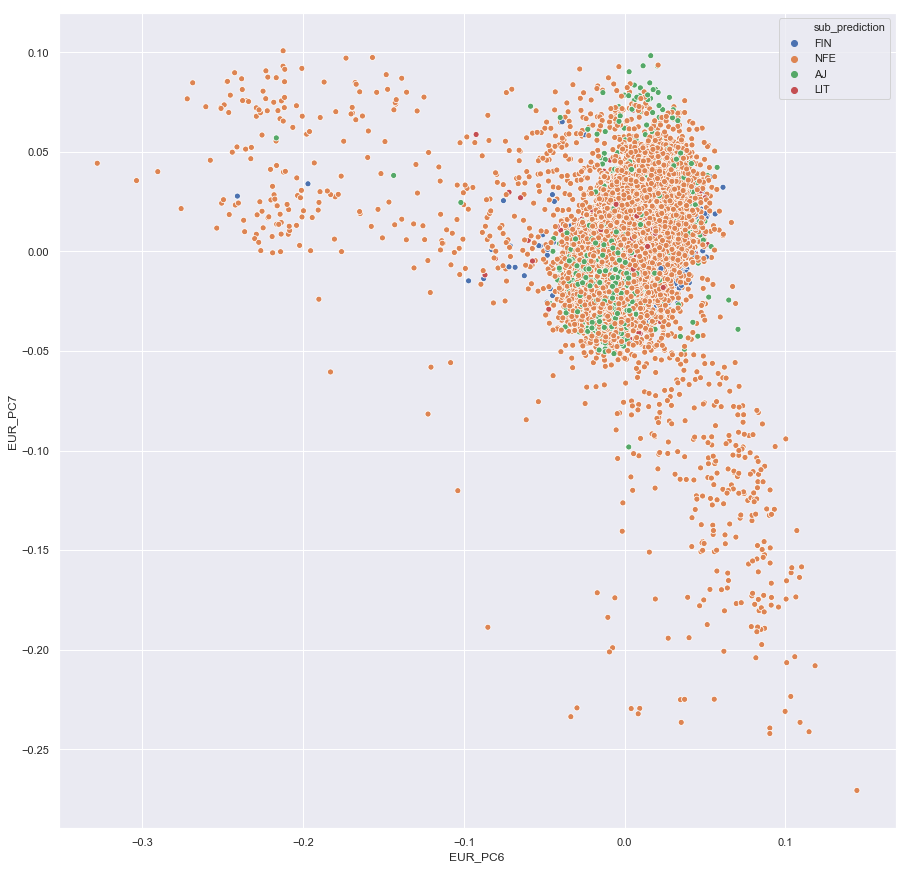

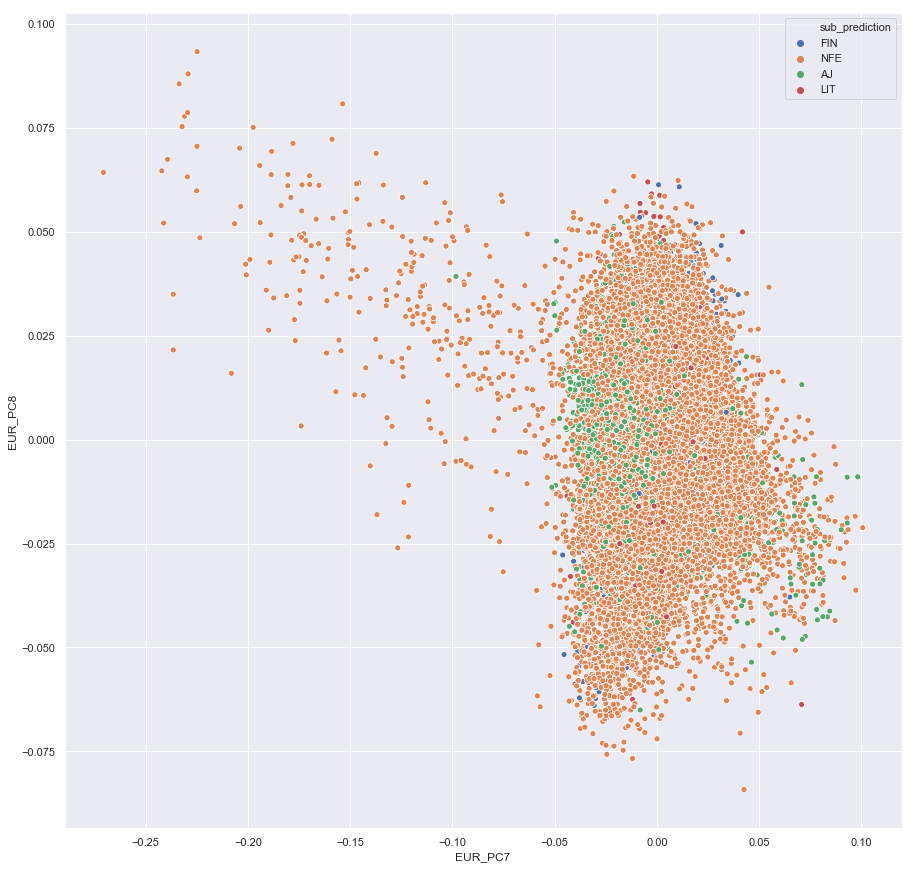

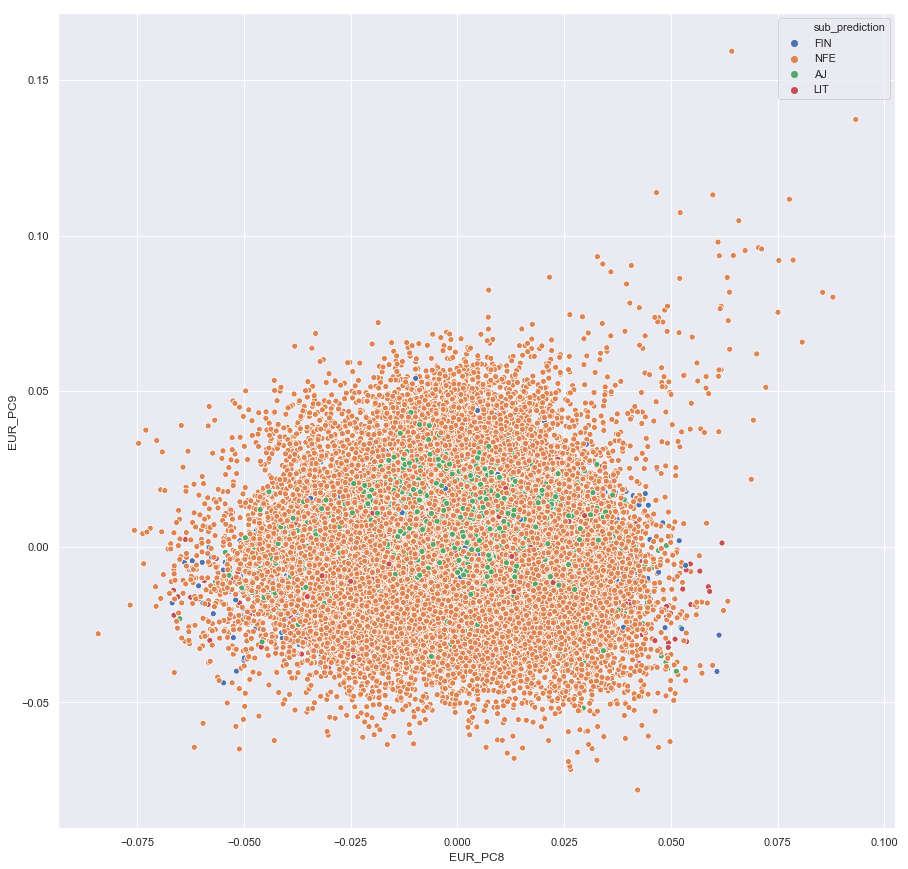

In [74]:
eur_cols = ['EUR_PC' + str(i) for i in range(10)]
for i in range(9):
    plt.figure(figsize=(15,15))
    sns.set()
    sns.scatterplot(eur_cols[i], eur_cols[i+1], hue='sub_prediction', data=pc_data[pc_data['s'].isin(list(eur_pc_data['s']))])

### Part 3: Redoing PCA after Removing Finns and Lithuanians

These populations are distinct enough from AJs and NFEs that they will stand alone. We freeze Finnish and Lithuanian populations, and continue to compute PCs for those remaining. 

In [77]:
if not os.path.exists('pc_data_fin_lit_freeze.tsv'):
    print("Writing...")
    pc_data.to_csv('pc_data_fin_lit_freeze.tsv', sep='\t', index=False)

Writing...


In [79]:
pc_data = pd.read_table('pc_data_fin_lit_freeze.tsv')
aj_nfe_samples_to_pca = list(pc_data[(pc_data['sub_prediction'] == 'AJ') | (pc_data['sub_prediction'] == 'NFE')]['s'])
if not os.path.exists('aj_nfe_samples_to_pca.tsv'):
    with open('aj_nfe_samples_to_pca.tsv', 'w') as f:
        print("Writing...")
        f.write("s\n")
        for item in list(aj_nfe_samples_to_pca):
            f.write("%s\n" % item)

Writing...


/Users/guhan/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (57) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


We now copy this sample list to the Google Cloud and run `aj_nfe_pca.py`, which excludes Finns and Lithuanians and runs PCA for only the rest. The next step is to "unlabel" those AJ and NFE samples that seem like outliers for their respective classes - we visualize the first couple of PCs below.

In [81]:
# FOR DETERMINING UNLABELING CRITERIA
aj_nfe_pc_data = clean_eur_pc_data('aj_nfe_40_pca_scores.tsv', 40, 'AJNFE_PC')
aj_nfe_train_pc_data = aj_nfe_pc_data[aj_nfe_pc_data['s'].isin(eur_train_data)].merge(pc_data)
aj_nfe_test_pc_data = aj_nfe_pc_data[aj_nfe_pc_data['s'].isin(eur_test_data)].merge(pc_data)

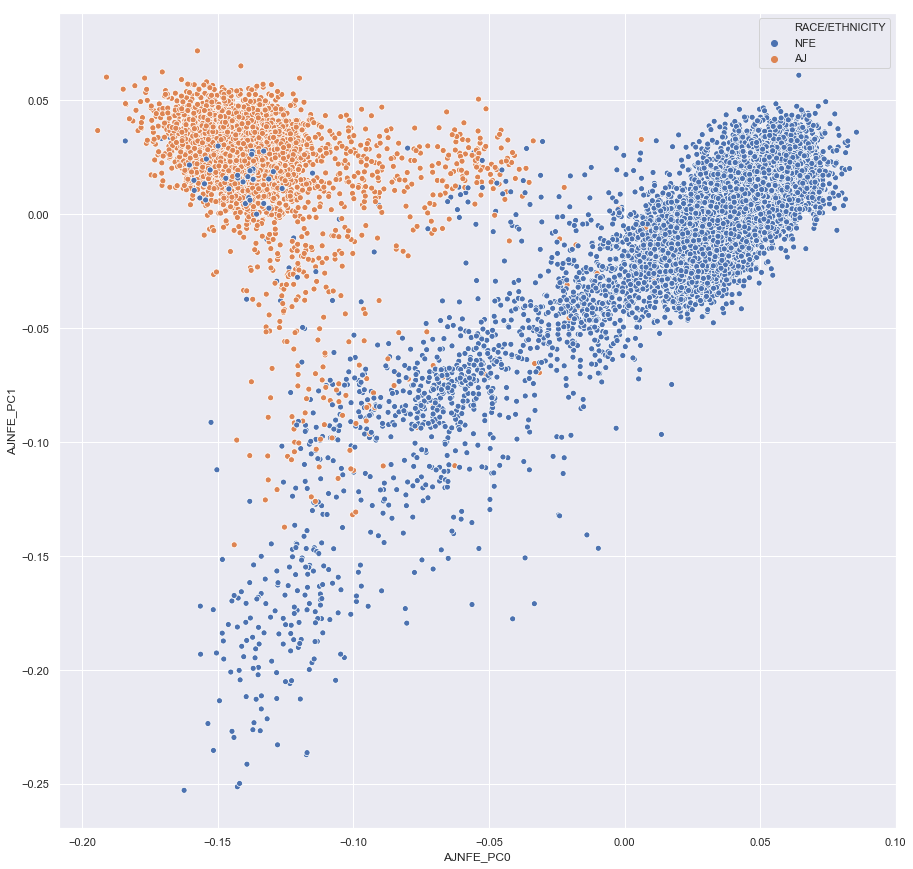

In [85]:
aj_nfe_cols = ['AJNFE_PC' + str(i) for i in range(10)]
sns.set()

# Creates four polar axes, and accesses them through the returned array
plt.figure(figsize=(15,15))
sns.scatterplot('AJNFE_PC0', 'AJNFE_PC1', hue='RACE/ETHNICITY', data=aj_nfe_train_pc_data)

Based on the plots above, it seems that those AJ samples that have `AJNFE_PC0 > -0.075` and `AJNFE_PC1 < -0.05` are questionable. Similarly, NFE samples with `AJNFE_PC0 > -0.1` and `AJNFE_PC1 > -0.05` seem fishy. We unlabel these below, then train the same type of classifier on the new train/test split, treating these questionable samples as test data.

In [113]:
#Find samples to unlabel

samples_to_unlabel = list(aj_nfe_train_pc_data[((aj_nfe_train_pc_data['RACE/ETHNICITY'] == 'AJ') & (aj_nfe_train_pc_data['AJNFE_PC0'] > -0.075) & (aj_nfe_train_pc_data['AJNFE_PC1'] < -0.05)) |
                                              ((aj_nfe_train_pc_data['RACE/ETHNICITY'] == 'NFE') & (aj_nfe_train_pc_data['AJNFE_PC0'] < -0.1) & (aj_nfe_train_pc_data['AJNFE_PC1'] > -0.05))]['s'])

new_eur_train_data = list((set(eur_train_data) - set(samples_to_unlabel)).intersection(aj_nfe_samples_to_pca))
new_eur_test_data = list(set(eur_test_data).union(samples_to_unlabel).intersection(aj_nfe_samples_to_pca))

print(len(eur_train_data), len(eur_test_data))
print(len(new_eur_train_data), len(new_eur_test_data))

24226 25076
16666 24825


In [149]:
# Retrain new model

new_eur_train_pc_data = eur_outlier_pc_data[eur_outlier_pc_data['s'].isin(new_eur_train_data)].merge(pc_data[['s', 'sup_prediction', 'dataset', 'sub_prediction']])
new_eur_test_pc_data = eur_outlier_pc_data[eur_outlier_pc_data['s'].isin(new_eur_test_data)].merge(pc_data[['s', 'sup_prediction', 'dataset', 'sub_prediction']])

new_eur_rfc = RandomForestClassifier()
new_eur_rfc.fit(new_eur_train_pc_data[X_train], new_eur_train_pc_data[y_train])
new_eur_test_pc_data['eur_prediction'] = new_eur_rfc.predict(new_eur_test_pc_data[X_train])
new_eur_train_pc_data['eur_prediction'] = np.nan

new_eur_pc_data = pd.concat([new_eur_train_pc_data, new_eur_test_pc_data])

new_pc_data = pc_data[['s', 'sup_prediction', 'dataset', 'sub_prediction']]

new_pc_data = new_pc_data[~new_pc_data['s'].isin(outliers)]
new_pc_data = new_eur_pc_data.merge(new_pc_data, how='outer')

for i, row in pc_data.iterrows():
    if new_pc_data.at[i, 's'] in list(new_eur_test_pc_data['s']):
        new_pc_data.at[i, 'sub_prediction'] = new_pc_data.at[i, 'eur_prediction']

s                     0
EUR_PC0           20468
EUR_PC1           20468
EUR_PC2           20468
EUR_PC3           20468
EUR_PC4           20468
EUR_PC5           20468
EUR_PC6           20468
EUR_PC7           20468
EUR_PC8           20468
EUR_PC9           20468
EUR_PC10          20468
EUR_PC11          20468
EUR_PC12          20468
EUR_PC13          20468
EUR_PC14          20468
EUR_PC15          20468
EUR_PC16          20468
EUR_PC17          20468
EUR_PC18          20468
EUR_PC19          20468
EUR_PC20          20468
EUR_PC21          20468
EUR_PC22          20468
EUR_PC23          20468
EUR_PC24          20468
EUR_PC25          20468
EUR_PC26          20468
EUR_PC27          20468
EUR_PC28          20468
EUR_PC29          20468
EUR_PC30          20468
EUR_PC31          20468
EUR_PC32          20468
EUR_PC33          20468
EUR_PC34          20468
EUR_PC35          20468
EUR_PC36          20468
EUR_PC37          20468
EUR_PC38          20468
EUR_PC39          20468
RACE/ETHNICITY  

In [149]:
eur_cols = ['EUR_PC' + str(i) for i in range(10)]
for i in range(9):
    plt.figure(figsize=(15,15))
    sns.set()
    sns.scatterplot(eur_cols[i], eur_cols[i+1], hue='sub_prediction', data=pc_data[pc_data['s'].isin(list(eur_pc_data['s']))])

s                     0
EUR_PC0           20468
EUR_PC1           20468
EUR_PC2           20468
EUR_PC3           20468
EUR_PC4           20468
EUR_PC5           20468
EUR_PC6           20468
EUR_PC7           20468
EUR_PC8           20468
EUR_PC9           20468
EUR_PC10          20468
EUR_PC11          20468
EUR_PC12          20468
EUR_PC13          20468
EUR_PC14          20468
EUR_PC15          20468
EUR_PC16          20468
EUR_PC17          20468
EUR_PC18          20468
EUR_PC19          20468
EUR_PC20          20468
EUR_PC21          20468
EUR_PC22          20468
EUR_PC23          20468
EUR_PC24          20468
EUR_PC25          20468
EUR_PC26          20468
EUR_PC27          20468
EUR_PC28          20468
EUR_PC29          20468
EUR_PC30          20468
EUR_PC31          20468
EUR_PC32          20468
EUR_PC33          20468
EUR_PC34          20468
EUR_PC35          20468
EUR_PC36          20468
EUR_PC37          20468
EUR_PC38          20468
EUR_PC39          20468
RACE/ETHNICITY  

Some samples erroneously were classified as South Asians across our datasets. If not explicitly from 1kG samples that are actually SAS, we assume that these samples were actually AMR samples that were misclassified.

In [ ]:
# #Replace all SAS with AMR BUT NOT THOSE IN KG
# for i, row in pc_data.iterrows():
#     if pc_data.at[i, 's'] not in kg_samples and pc_data.at[i, 'sub_prediction'] == 'SAS':
#         pc_data.at[i, 'sub_prediction'] = 'AMR'

In [ ]:
# # Drop unnecessary columns
# pc_data = pc_data.drop(['eur_prediction'], axis=1)
# if not os.path.exists('pc_data_sub_predictions_090619.tsv'):
#     print("Writing...")
#     pc_data.to_csv('pc_data_sub_predictions_090619.tsv', sep='\t', index=False)

And there we have it - finalized labels for all samples in our datasets. This was also frozen in the cell above. Enjoy the pretty picture.

In [ ]:
# #pc_data = pd.read_table('pc_data_sub_predictions_090619.tsv')
# plt.figure(figsize=(15,15))
# sns.set()
# sns.scatterplot('PC0', 'PC1', hue='sub_prediction', data=pc_data)#, 

The final step is to generate the lists needed to run future analyses - GWAS, local ancestry painting, etc.

- AJ, EAS, FIN, LIT, NFE, SAS  samples are written to file
- AMR, HISPANIC, and PUERTO RICAN samples are combined into one file (HIS) for future local ancestry painting
- AFR are also written to file for future local ancestry painting

In [ ]:
# pc_data.to_csv('pc_data_sub_predictions_091119.tsv', sep='\t', index=False)

In [ ]:
# for pop in ['AJ', 'EAS', 'FIN', 'LIT', 'NFE', 'SAS']:
#     df = pc_data[pc_data['sub_prediction'] == pop]
#     df[['s', 'COHORT', 'dataset', 'DIAGNOSIS']].to_csv('final_population_lists/' + pop + '_sample_list.tsv', sep='\t', index=False)

# pc_data[pc_data['sub_prediction'].isin(['AMR', 'HISPANIC', 'PUERTO RICAN'])][['s', 'COHORT', 'dataset', 'DIAGNOSIS']].to_csv('final_population_lists/HIS_sample_list.tsv', sep='\t', index=False)
# pc_data[pc_data['sub_prediction'] == 'AFR'][['s', 'COHORT', 'dataset', 'DIAGNOSIS']].to_csv('final_population_lists/AFR_sample_list.tsv', sep='\t', index=False)

In [ ]:
# pc_data.groupby('sub_prediction').count()['s']

In [ ]:
# #pc_data = pd.read_table('pc_data_sub_predictions_090619.tsv')
# # for pop in np.unique(pc_data['RACE/ETHNICITY']):
# #     fig, ax = plt.subplots(figsize=(15,15))
# #     sns.set()
# #     sns.scatterplot('EUR_PC0', 'EUR_PC1', hue='COHORT', data=pc_data[(pc_data['RACE/ETHNICITY'] == pop)], ax=ax)
# #     ax.set_title(pop)
# #     ax.set_ylim(-0.35, 0.35)
# #     ax.set_xlim(-0.25, 0.45)

# fig, ax = plt.subplots(figsize=(15,15))
# sns.set()
# sns.scatterplot('EUR_PC0', 'EUR_PC1', hue='RACE/ETHNICITY', data=pc_data[(pc_data['RACE/ETHNICITY'].isin(['AJ', 'NFE', 'FIN', 'LIT']))])# | (pc_data['RACE/ETHNICITY'] == 'NFE')], ax=ax)
# # fig, ax = plt.subplots(figsize=(15,15))
# # sns.set()
# # sns.scatterplot('EUR_PC0', 'EUR_PC1', hue='COHORT', data=pc_data[(pc_data['RACE/ETHNICITY'] == 'NFE')])# | (pc_data['RACE/ETHNICITY'] == 'NFE')], ax=ax)